In [1]:
import anndata
import scanpy as sc
from pandas import read_csv

In [2]:
filters = read_csv('samplesheet_scrnaseq_preprocessing.csv')

dataset_str = 'Lambrechts_2018_LUAD_6653'

id_row = filters[filters.id == dataset_str]
file_str = id_row.input_adata.iloc[0].split('/')[-1]

In [3]:
thresholds = {}
thresholds['min_counts']  = int(id_row.min_counts)
thresholds['max_counts'] = int(id_row.max_counts)
thresholds['min_genes'] = int(id_row.min_genes)
thresholds['max_genes'] = int(id_row.max_genes)
thresholds['max_pct_mito'] = int(id_row.max_pct_mito)

adata = anndata.read_h5ad(f'/root/datos/maestria/netopaas/luca/data/12_input_adatas/{file_str}')

/tmp/ipykernel_1288/1983533706.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  thresholds['min_counts']  = int(id_row.min_counts)
/tmp/ipykernel_1288/1983533706.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  thresholds['max_counts'] = int(id_row.max_counts)
/tmp/ipykernel_1288/1983533706.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  thresholds['min_genes'] = int(id_row.min_genes)
/tmp/ipykernel_1288/1983533706.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  thresholds['max_genes'] = int(id_row.max_genes)
/tmp/ipykernel_1288/1983533706.py:6: FutureWarning: Calling int on a single element Series 

In [7]:
adata.obs.dtypes

dataset      category
sample       category
patient         int64
origin       category
condition    category
platform     category
age             int64
sex          category
tissue       category
dtype: object

In [5]:
adata.obs.condition

index
AAACCTGCATTCTCAT-1_0     LUAD
AAACCTGGTGCGAAAC-1_0     LUAD
AAACCTGTCAGCGACC-1_0     LUAD
AAACGGGAGACGACGT-1_0     LUAD
AAACGGGCAGATCGGA-1_0     LUAD
                         ... 
TTTGTCAAGTGAACGC-1_11    LUAD
TTTGTCACAAAGCGGT-1_11    LUAD
TTTGTCACACCTCGTT-1_11    LUAD
TTTGTCAGTAATAGCA-1_11    LUAD
TTTGTCATCGCTGATA-1_11    LUAD
Name: condition, Length: 36589, dtype: category
Categories (1, object): ['LUAD']

In [6]:
# very basic gene filtering - genes with 0 cells cause some downstream processes to fail.
print("Filtering genes")
print(f"    Before: {adata.shape[1]}")
sc.pp.filter_genes(adata, min_counts=3)
print(f"    After: {adata.shape[1]}")

# %%
# Apply thresholds
print("Filter by min_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_counts=thresholds["min_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_counts")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_counts=thresholds["max_counts"])
print(f"    After: {adata.shape[0]}")


print("Filter by min_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, min_genes=thresholds["min_genes"])
print(f"    After: {adata.shape[0]}")


print("Filter by max_genes")
print(f"    Before: {adata.shape[0]}")
sc.pp.filter_cells(adata, max_genes=thresholds["max_genes"])
print(f"    After: {adata.shape[0]}")

# %%
if "mito" not in adata.var.columns:
    adata.var["mito"] = adata.var_names.str.lower().str.startswith("mt-")

# %%
sc.pp.calculate_qc_metrics(
    adata, qc_vars=("mito",), log1p=False, inplace=True, percent_top=None
)

print("Filter by max_pct_mito")
print(f"    Before: {adata.shape[0]}")
adata = adata[adata.obs["pct_counts_mito"] < thresholds["max_pct_mito"]].copy()
print(f"    After: {adata.shape[0]}")

Filtering genes
    Before: 36601
    After: 26359
Filter by min_counts
    Before: 36589
    After: 30839
Filter by max_counts
    Before: 30839
    After: 30424
Filter by min_genes
    Before: 30424
    After: 27427
Filter by max_genes
    Before: 27427
    After: 27427
Filter by max_pct_mito
    Before: 27427
    After: 26514


## 3.1.1 Automated annotation

For a more detailed walkthrough of the process go to `../HCA-Lung/AutoLung.ipynb` or even https://docs.scarches.org/en/latest/hlca_map_classify.html

IT IS IMPORTANT THAT THE QUERY DATA IS IN RAW COUNTS, WE CHECK THAT HERE:


In [7]:
adata.X[:10, :30].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [7]:
import pandas as pd
import anndata as ad
import numpy as np

import scarches as sca
import gdown
import gzip
import shutil
from scipy import sparse

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

import sys, os
sys.path.append(os.path.join(os.getcwd(), '../single-cell-tutorial/download_scripts'))
from functions import remove_repeated_var_inds, join_map_mart

/usr/local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


### Load Query dataset

In [8]:
batch_key = 'dataset'
name = dataset_str.split('_')[0]
query_batch = [f'lung_{name}']
cell_type_key = 'scanvi_label'
data_dir = '/root/datos/maestria/netopaas/lung_scRNA'
backup_dir = '/root/datos/maestria/netopaas/luca_explore'
ref_model_path = f'{data_dir}/HCA_Lung/HLCA_reference_model'

#Important to check how many epochs would be ideal
surgery_epochs = 100
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [10]:
adata_ref = sc.read_h5ad(f'{data_dir}/HCA_Lung/HLCA_emb_and_metadata.h5ad')

In [11]:
adata_query_unprep = adata.copy()

# We need RAW count data for the model we are using so we get it from adata.layers
#adata_query_unprep.X = adata_query_unprep.layers['counts']

For faster computation convert the matrix to sparse.
First check with `adata.X` if it is sparse

In [12]:
adata.X
# adata_query_unprep.X = sparse.csr_matrix(adata_query_unprep.X)

<26514x26359 sparse matrix of type '<class 'numpy.float32'>'
	with 44188533 stored elements in Compressed Sparse Row format>

### Change to Ensembl IDs

Revert to ensemble ids using the assembly reference gch38 (or hg19 in the comments) used in the experiment.
Doing this via THE PACKAGE Biomart always leaves us with some gaps because there are many manually annotated genes.

**WARNING**
Lost only 5% of genes with this method

Chen uses:
- Chemistry 10x 3' v2
- CellRanger 3.2.0 for fastq generation
- STAR with GRCh38

I have sent an email to ask for the assembly used in STAR.
Other ideas to figure this out : 
- Figuring in what assembly some of the lost genes are
- Check the SAM/BAM Header

If your query feature naming does not match your reference model feature naming, you will need to add the right feature names. For the HLCA reference, the mapping of the 2000 input gene IDs to their gene names is stored on the HLCA Zenodo page, so you can add gene ids using that mapping. Alternatively, you can map your gene IDs to gene names (or the reverse) using BioMart mapping tables. In most cases your raw data includes both gene IDs and names, in which case mapping is not necessary.

Let’s download the HLCA-specific gene mapping:

In [13]:
path_gene_mapping_df = f'{data_dir}/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv'

In [18]:
# Download gene information from HLCA github:
url = "https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv"
gdown.download(url, path_gene_mapping_df, quiet=False)

Downloading...
From: https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv
To: /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv
45.1kB [00:00, 54.0MB/s]


'/root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv'

In [14]:
gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)

# Store your gene names in an adata.var.column if they are currently the index:
# if gene names are in .var.index:
adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index
gene_name_column_name = "gene_names"

Map gene names to gene ids for all of the 2000 reference model genes that we can find in our data:

Check number of detected genes:

In [15]:
n_overlap = (
    adata_query_unprep.var[gene_name_column_name]
    .isin(gene_id_to_gene_name_df.gene_symbol)
    .sum()
)
n_genes_model = gene_id_to_gene_name_df.shape[0]
print(
    f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
)



Number of model input genes detected: 1885 out of 2000 (94%)


Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above. Store the resulting ids both in the .var.index (for scArches) and in a .var[gene_ids] (for merging duplicate genes).

In [16]:
adata_query_unprep = adata_query_unprep[
    :,
    adata_query_unprep.var[gene_name_column_name].isin(
        gene_id_to_gene_name_df.gene_symbol
    ),
].copy()  # subset your data to genes used in the reference model
adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
    dict(zip(gene_id_to_gene_name_df.gene_symbol, gene_id_to_gene_name_df.index))
)  # add gene ids for the gene names, and store in .var.index
# remove index name to prevent bugs later on
adata_query_unprep.var.index.name = None
adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index


In [17]:
adata_query_unprep.var.head(3)

,n_counts,mito,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,gene_names,gene_ids
ENSG00000188290,2126.0,False,952,0.051591,96.528968,1415.0,HES4,ENSG00000188290
ENSG00000187608,43652.0,False,11596,1.277610,57.720494,35041.0,ISG15,ENSG00000187608
ENSG00000162571,460.0,False,179,0.012725,99.347358,349.0,TTLL10,ENSG00000162571


In [18]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    adata.obs[col] = adata.obs[col].astype('category')
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    cat = adata.obs[col].values
    indicator = sparse.coo_matrix(
        (np.broadcast_to(True, adata.n_obs), (cat.codes, np.arange(adata.n_obs))),
        shape=(len(cat.categories), adata.n_obs),
    )

    return ad.AnnData(
        indicator @ adata.X, var=adata.var, obs=pd.DataFrame(index=cat.categories)
    )

shape before merging:

Now merge. Note that all var columns will be dropped after merging (as we don’t specify how to merge). As the merging is done based on .obs indices in the function above, we transpose our anndata object and re-transpose it after merging.

In [19]:
adata_query_unprep = sum_by(adata_query_unprep.transpose(), col="gene_ids").transpose()

In [20]:
adata_query_unprep.shape

(26514, 1885)

add back gene ids:

In [21]:
adata_query_unprep.var = adata_query_unprep.var.join(gene_id_to_gene_name_df).rename(columns={"gene_symbol":"gene_names"})

### Surgery

We pad missing query genes with zeros and reorder the available ones to ensure data corectness and smooth running of the scArches reference mapping.

In [22]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = adata_query_unprep,
    # return_reference_var_names=True,
    reference_model = ref_model_path,
    inplace=False)

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   
INFO     Found 94.25% reference vars in query data.                                                                


This line should be kept unchanged due to the structure of the pre-trained reference model.

In [23]:
adata_query.obs['scanvi_label'] = 'unlabeled'

Now we perform scArches “surgery”.

Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [24]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(ref_model_path, load_adata=False, map_location='cpu')

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


Thanks to exploring the model we can deduce what .obs we need and the name we assigned. In this case we need to define a 'dataset'
column in obs to define the batches. Seeing as to how every sample ia new day in the experiment we define the batches as the samples.

We can load the model with this command or train it if we havent got it

In [25]:
adata_query.obs['dataset'] = adata_query.obs['sample']
adata_query.obs['sample'] = adata_query.obs['sample'].astype('string')
adata_query.obs['dataset'] = adata_query.obs['dataset'].astype('string')

In [26]:
for col in adata_query.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_query.obs[col]):
        adata_query.obs[col] = adata_query.obs[col].astype('str')


In [27]:
# Convert all mito falgs into false because we are using the latent genes of the HCA_lung model
adata_query = sc.read_h5ad(f'{backup_dir}/surgeries/query_{name}.h5ad')
adata_query.var.mito = False
# adata_query.write_h5ad(f'{backup_dir}/surgeries/query_{name}.h5ad')

Apparently we have to aks for cuda availability explicitly for scArches to recognize that we have GPU

In [30]:
import torch
torch.cuda.is_available()

True

In [31]:
surgery_model = sca.models.SCANVI.load_query_data(
        adata_query,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


In [32]:
%%time
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 100 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.24it/s, v_num=1, train_loss_step=496, train_loss_epoch=433]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s, v_num=1, train_loss_step=496, train_loss_epoch=433]
CPU times: user 1min 21s, sys: 538 ms, total: 1min 21s
Wall time: 1min 21s


In [33]:
surgery_model.save(f'{backup_dir}/surgeries/{name}', overwrite=True)

In [24]:
surgery_model = sca.models.SCANVI.load(f'{backup_dir}/surgeries/{name}/', adata_query)

INFO     File surgeries/Chen/model.pt already downloaded                                                           


### Get latent representation
Here we will calculate the “latent representation”, or “low-dimensional embedding” of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.!

In [34]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index,:]

In [35]:
adata_query_latent.write_h5ad(f'{backup_dir}/surgeries/latent_{name}.h5ad')

In [36]:
adata_query_latent = sc.read_h5ad(f'{backup_dir}/surgeries/latent_{name}.h5ad')

### Combine embeddings
We add “reference or query” metadata to acquire more information and better analyse the integration level.

In [37]:
adata_query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. “_” and batch_key to the obs column that you want to use as barcode suffix (e.g. “dataset”).

In [38]:
combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [20]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [11]:
combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

### Label transfer
Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5). Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we “propagate” to the higher levels, i.e. you will see “3_Mast cells” in level 4 and 5 annotations. (Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [21]:
celltypes = f'{data_dir}/HCA_Lung/HLCA_celltypes_ordered.csv'

In [25]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
gdown.download(url, celltypes, quiet=False)

Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv
To: /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_celltypes_ordered.csv
5.81kB [00:00, 35.9MB/s]                                                                                                                                                                                                                                                                  


'/root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_celltypes_ordered.csv'

In [24]:
cts_ordered = read_csv(celltypes,index_col=0)

In [22]:
#Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [26]:
%%time

labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = adata_ref.obs.join(cts_ordered, on='ann_finest_level')
    )

finished!
CPU times: user 9min 31s, sys: 1.77 s, total: 9min 32s
Wall time: 1min 39s


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to “unknown” instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

In [27]:
uncertainty_threshold = 0.2

In [28]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [29]:
t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]

Convert uncertainties to arrays

In [30]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set “nan” to NaN

In [31]:
def remove_uncert_types(combined_emb):
    import pandas as pd
    t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
    t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]
    
    combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

    for col, uncert in zip(t_labels,t_uncert):
        filtered_colname = col.replace('_unfiltered','')
        # too high uncertainty levels => set to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname] = combined_emb.obs[filtered_colname].astype('str')
        combined_emb.obs[filtered_colname].mask(
            combined_emb.obs[uncert] > uncertainty_threshold,
            'Unknown',
            inplace = True)

        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace('nan',np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)
    return combined_emb

In [17]:
combined_emb.obs['original_ann_level_2']

GCGACCATCCCTAACC_SC22                Myeloid
P2_1_GCGCAACCAGTTAACC               Lymphoid
GCTCTGTAGTGCTGCC_SC27    Alveolar epithelium
P2_8_TTAGGACGTTCAGGCC                Myeloid
CTTGATTGTCAGTTTG_T164      Airway epithelium
                                ...         
TTGCTAACAGTACC-1_6                       NaN
TTGCTAACCTCAGA-1_6                       NaN
TTGTAGCTCACTTT-1_6                       NaN
TTTAGAGAGTTTGG-1_6                       NaN
TTTATCCTGCTAAC-1_6                       NaN
Name: original_ann_level_2, Length: 588947, dtype: category
Categories (13, object): ['Airway epithelium', 'Alveolar epithelium', 'Blood vessels', 'Fibroblast lineage', ..., 'Myeloid', 'None', 'Smooth muscle', 'Submucosal Gland']

In [32]:
remove_uncert_types(combined_emb)

AnnData object with n_obs × n_vars = 716171 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [33]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")



Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 2.28%
Level 2: 7.13%
Level 3: 18.08%
Level 4: 33.35%
Level 5: 34.61%


### UMAP

The UMAP plots help us perform downstream analysis, like clustering, label transfer, integration and more.

#### UMAP Query vs. Reference

In [39]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [ ]:
combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [40]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

/usr/local/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [41]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [2]:
import scanpy as sc

In [9]:
combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


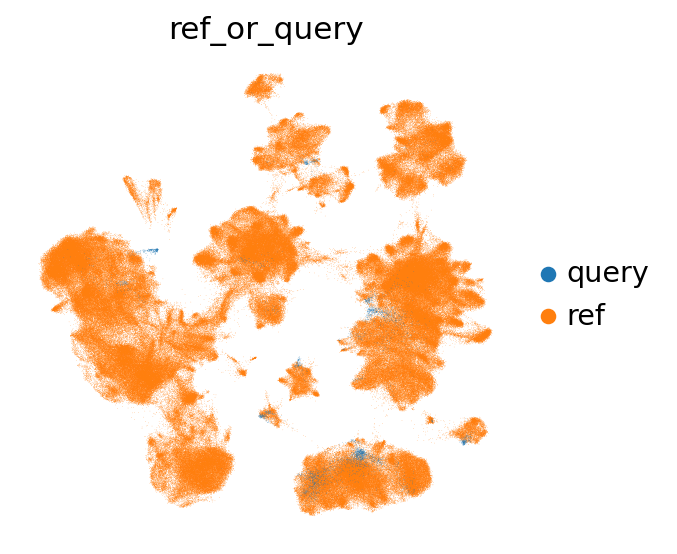

In [10]:
sc.pl.umap(
        combined_emb,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

#### UMAP Uncertainties

Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

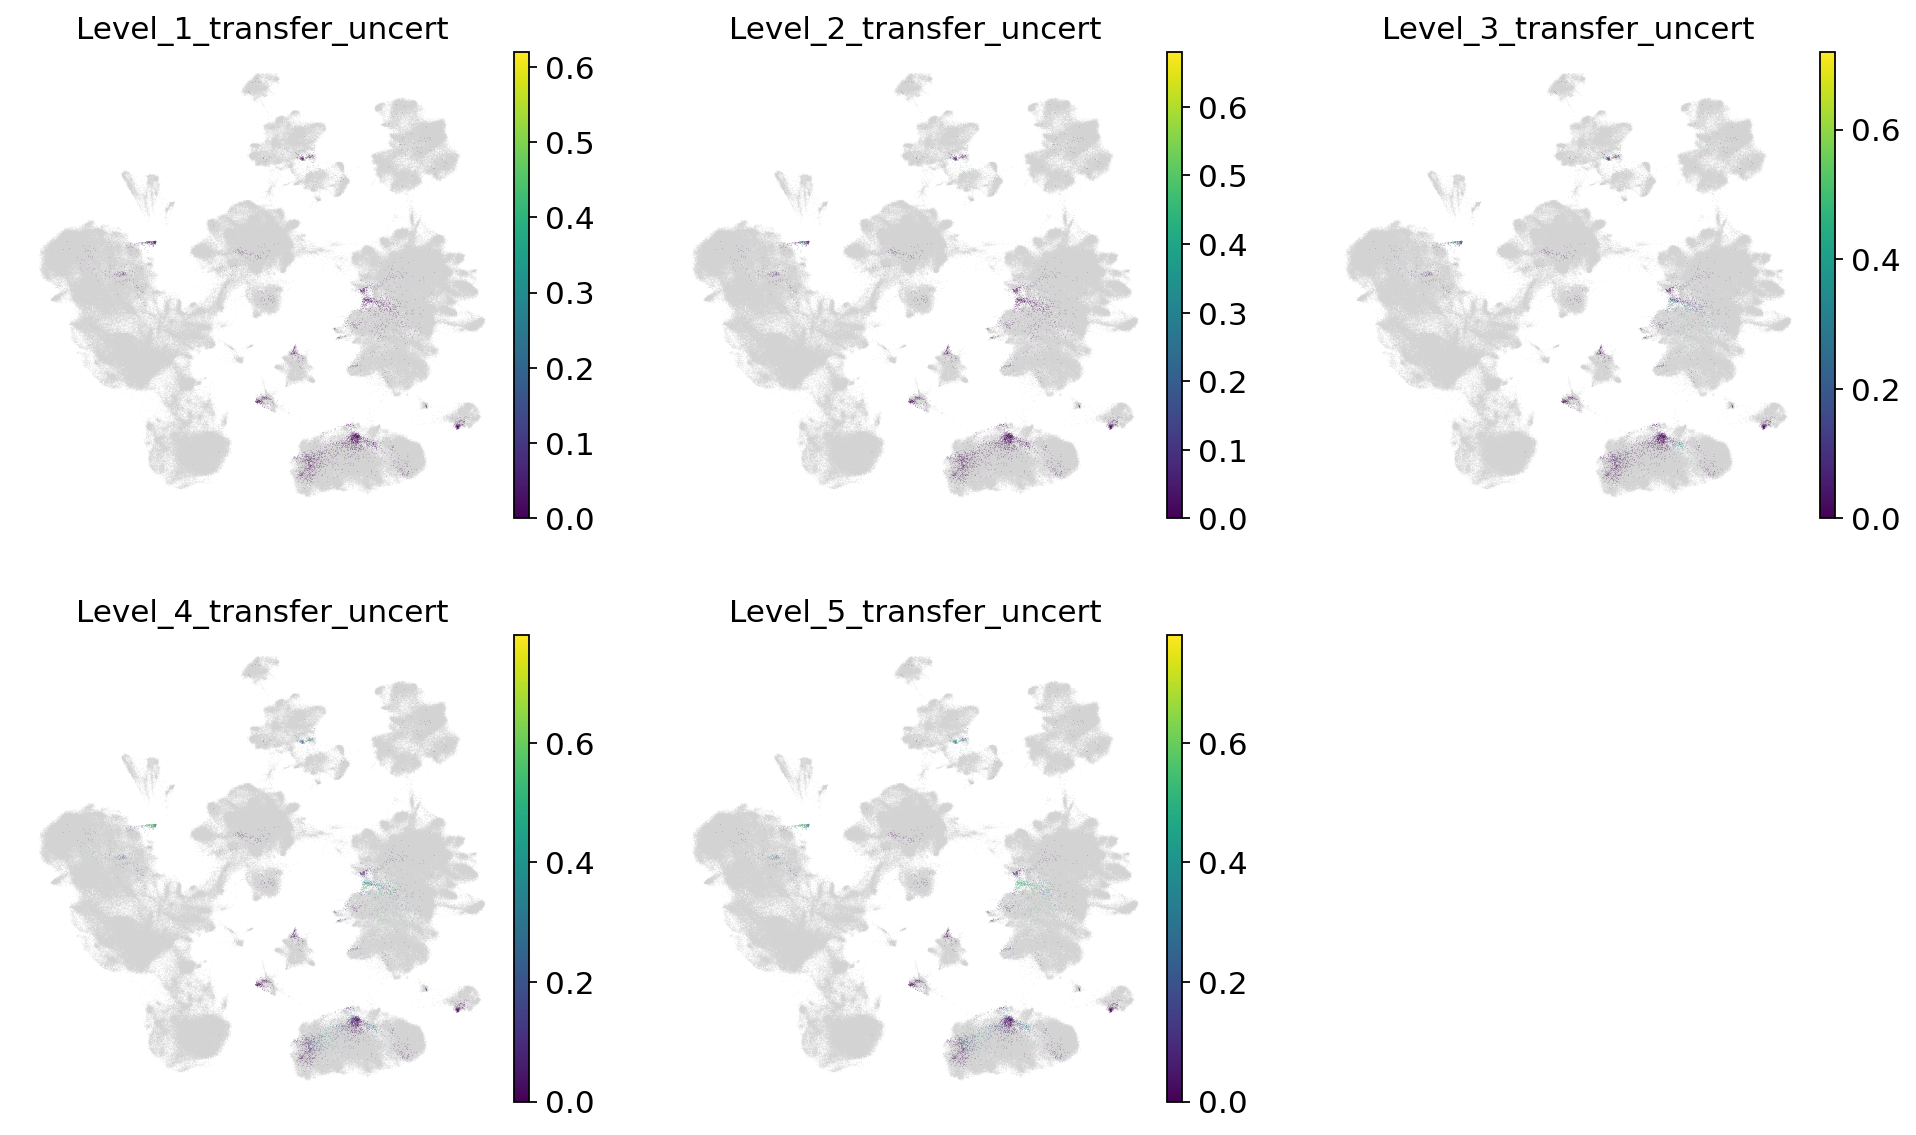

In [11]:
sc.pl.umap(
    combined_emb,
    color=[f'Level_{lev}_transfer_uncert' for lev in range(1,6)],
    ncols=3,
    frameon=False,
    )

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


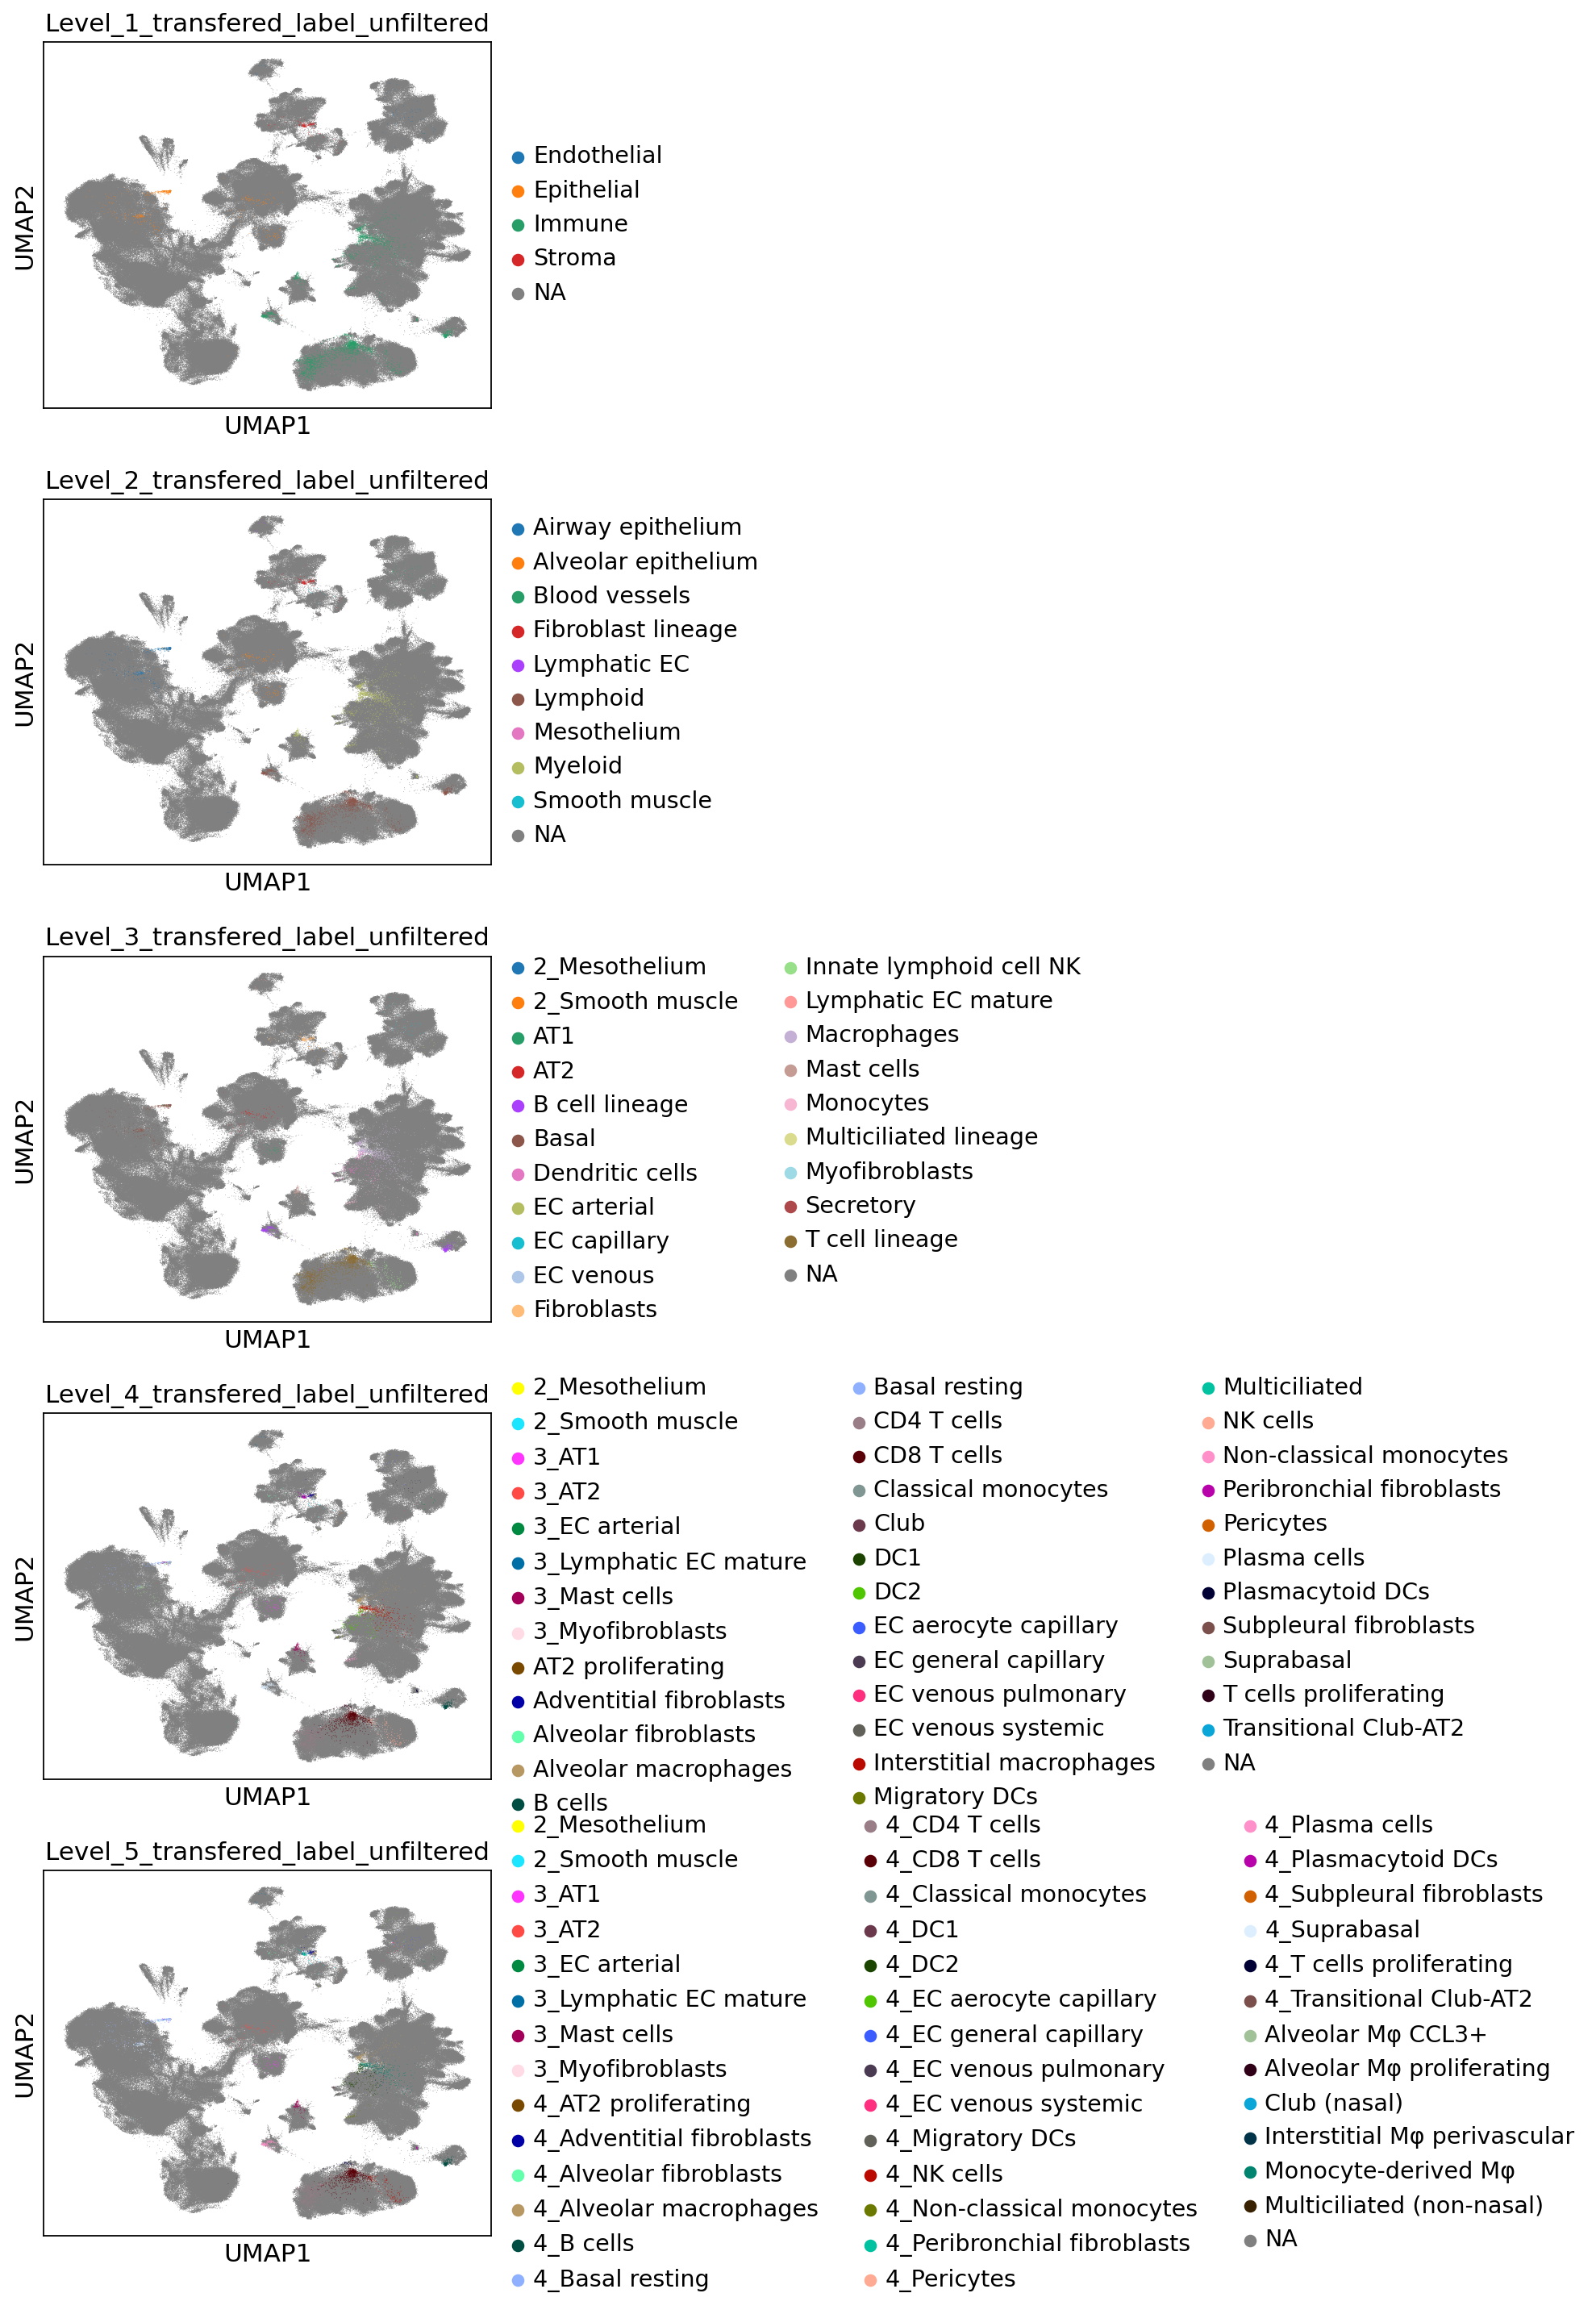

In [14]:
sc.pl.umap(
        combined_emb,
        color=[f"Level_{lev}_transfered_label_unfiltered" for lev in range(1,6)],
        na_color="grey",
        ncols=1,
        size=0.5
)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


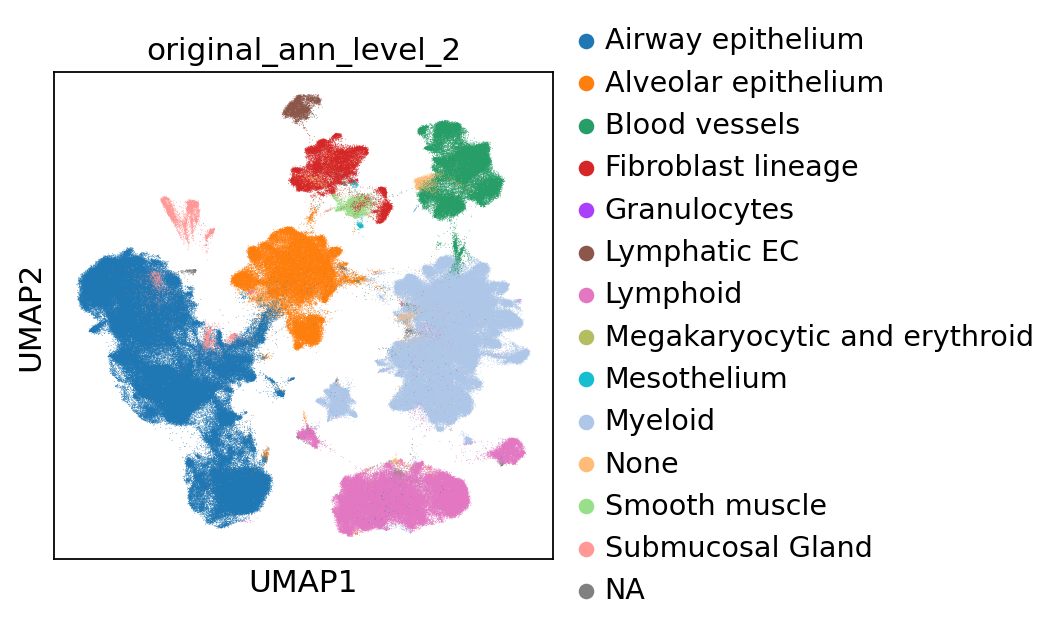

In [18]:
sc.pl.umap(
        combined_emb,
        color="original_ann_level_3",
        na_color="grey",
        ncols=1,
        size=0.5
)